In [1]:
%%capture
try:
    import jaxtyping
except ImportError:
    !pip install jaxtyping

In [2]:
# First, import necessary libraries.
import matplotlib.pyplot as plt
import scipy.signal as signal
import torch
import torch.distributions as dist

from jaxtyping import Float, Int
from torch import Tensor


In [4]:
# Load the data
data = torch.load("lab01_data.pt")
traces = data["traces"]
true_spike_times = data["true_spike_times"]
true_spike_ids = data["true_spike_ids"]
true_templates = data["true_templates"]

# Extract scalar constants 
SAMPLING_FREQUENCY = data["sampling_frequency"]
NUM_SAMPLES, NUM_CHANNELS = traces.shape
TRUE_NUM_SPIKES = true_spike_times.shape[0]
TRUE_NUM_NEURONS, WINDOW_SIZE, _ = true_templates.shape

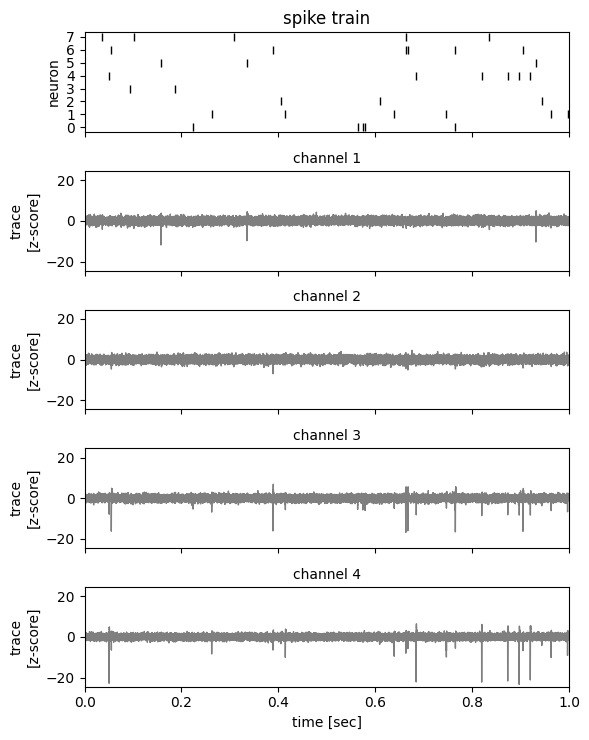

In [5]:
def plot_slice(traces: Float[Tensor, "num_samples num_channels"],
               spike_times: Int[Tensor, "num_spikes"],
               spike_ids: Int[Tensor, "num_spikes"],
               start_time: float=0,
               end_time: float=1.0,
               ylim: float=None):
    """
    Plot a slice of the recording and the corresponding spike times.

    Parameters
    ----------
    traces : torch.Tensor
        The voltage traces.
    spike_times : torch.Tensor
        The spike times, in samples.
    spike_ids : torch.Tensor
        The spike IDs, taking values 0,1,2,...,num_neurons-1
    start_time : float
        The start time of the slice, in seconds.
    end_time : float
        The end time of the slice, in seconds.
    ylim : float
        The y-limit for the traces. If None, it is set to 1.05 times the max absolute value of the traces.
    """
    # Extract constants
    num_samples, num_channels = traces.shape
    num_neurons = spike_ids.max() + 1

    # Extract the slice of the recording
    slc = slice(int(start_time * SAMPLING_FREQUENCY), int(end_time * SAMPLING_FREQUENCY))
    
    # Get the y-limit for traces if not specified
    if ylim is None:
        ylim = 1.05 * traces[slc].abs().max()

    # Make an array of times in seconds
    times_sec = torch.arange(0, num_samples) / SAMPLING_FREQUENCY
    spike_times_sec = times_sec[spike_times]
    spike_in_slice = (spike_times_sec >= start_time) & (spike_times_sec <= end_time)

    # Plot the spike raster
    fig, axs = plt.subplots(num_channels + 1, 1, sharex=True, figsize=(6, 1.5 * (num_channels + 1)))
    axs[0].plot(spike_times_sec[spike_in_slice], spike_ids[spike_in_slice], '|k', markersize=6)
    axs[0].set_ylabel("neuron")
    axs[0].set_yticks(torch.arange(0, num_neurons))
    axs[0].set_title("spike train")

    # Plot the voltage traces 
    for i in range(num_channels):
        axs[i+1].plot(times_sec[slc], traces[slc, i], color='k', lw=1, alpha=0.5)
        axs[i+1].set_title(f"channel {i+1}", fontsize=10)
        axs[i+1].set_ylim(-ylim, ylim)
        axs[i+1].set_ylabel("trace\n[z-score]")
        axs[i+1].set_xlim(start_time, end_time)
        if i == num_channels - 1: 
            axs[i+1].set_xlabel(f"time [sec]")
    
    plt.tight_layout()
    return fig, axs

def plot_waveforms(waveforms: Float[Tensor, "num_waveforms windows_size num_channels"],
                   name: str="waveform"):
    """
    Plot a grid of spike waveforms or templates.

    Parameters
    ----------
    waveforms : torch.Tensor
        The waveforms (or templates) to plot.

    name : str
        The name of the waveforms (or templates) to plot. Default is "waveform".
    """
    num_waveforms, window_size, num_channels = waveforms.shape
    times = torch.arange(-window_size//2, window_size//2) / SAMPLING_FREQUENCY * 1000
    fig, axs = plt.subplots(num_channels, num_waveforms, 
                            figsize=(1.25 * num_waveforms, 1.25 * num_channels), 
                            sharex=True, sharey=True)
    lim = 1.05 * waveforms.abs().max()
    for j in range(num_waveforms):
        for i in range(num_channels):
            axs[i,j].plot(times, waveforms[j,:,i], color='k', lw=1, alpha=0.5)
            axs[i,j].set_ylim(-lim, lim)
            # axs[i,j].set_xlabel("time [samples]")
            # axs[i,j].set_title(f"waveform {j}\n channel {i}")
            if j == 0:
                axs[i,j].set_ylabel(f"channel {i}\n [z-score]")
            if i == 0:
                axs[i,j].set_title(f"{name} {j}")
            if i == num_channels - 1:
                axs[i,j].set_xlabel(f"time [ms]")
    plt.tight_layout()
    
    return fig, axs

_ = plot_slice(
    traces,
    true_spike_times,
    true_spike_ids,
    start_time=0.0,
    end_time=1.0,
)

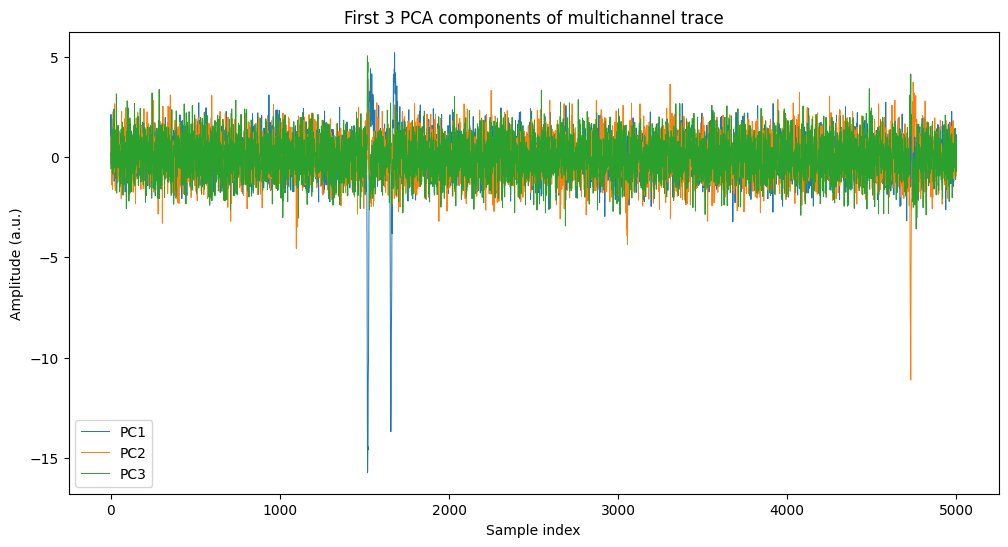

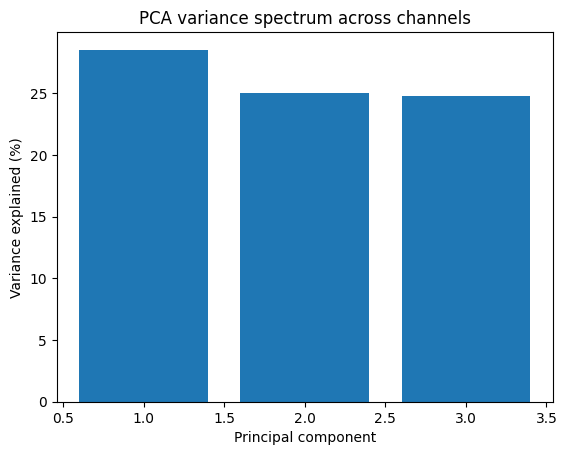

In [12]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Flatten across time for PCA across channels
X = traces.numpy()  # shape: (num_samples, num_channels)

# Standardize roughly (zero-mean per channel)
X_centered = X - X.mean(axis=0, keepdims=True)

# Fit PCA on channels
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_centered)

# Plot first few PCs as time series
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(X_pca[:5000, i], label=f"PC{i+1}", lw=0.7)
plt.legend()
plt.title("First 3 PCA components of multichannel trace")
plt.xlabel("Sample index")
plt.ylabel("Amplitude (a.u.)")
plt.show()

# Optional: explained variance
plt.bar(range(1, 4), pca.explained_variance_ratio_ * 100)
plt.xlabel("Principal component")
plt.ylabel("Variance explained (%)")
plt.title("PCA variance spectrum across channels")
plt.show()


In [6]:
traces.shape

torch.Size([3600000, 4])

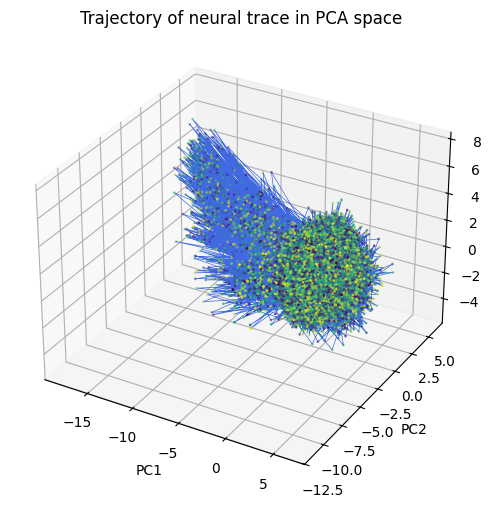

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # activates 3D projection
import numpy as np

# Project data to first 3 PCs
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_centered)

# Downsample to plot fewer points for clarity
stride = 10  # increase if it’s too dense
X3 = X_pca[::stride]
t3 = np.arange(X3.shape[0]) / SAMPLING_FREQUENCY * stride  # time in seconds

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot(X3[:, 0], X3[:, 1], X3[:, 2], lw=0.5, color="royalblue")
ax.set_title("Trajectory of neural trace in PCA space")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

# optional color by time
c = plt.cm.viridis((t3 - t3.min()) / (t3.max() - t3.min()))
ax.scatter(X3[:, 0], X3[:, 1], X3[:, 2], c=c, s=1)
plt.show()




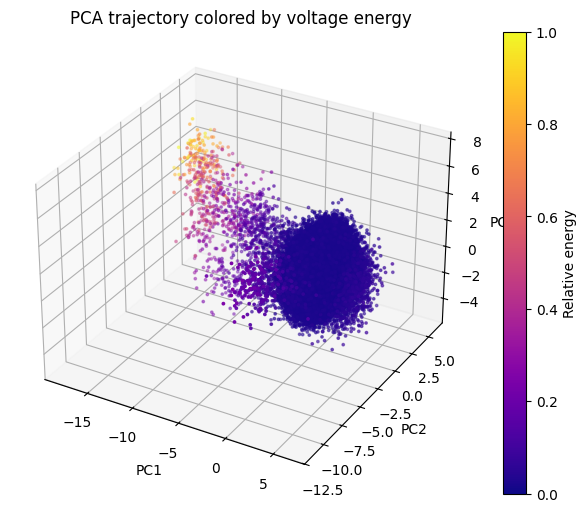

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Color by total voltage energy (sum of squares across channels)
energy = np.sum(X_centered[::stride] ** 2, axis=1)
energy = (energy - energy.min()) / (energy.max() - energy.min())

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(
    X3[:, 0], X3[:, 1], X3[:, 2],
    c=energy, cmap="plasma", s=3
)
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
ax.set_title("PCA trajectory colored by voltage energy")
fig.colorbar(p, ax=ax, label="Relative energy")
plt.show()
